In [1]:
from readinput import *
from loaddata import *
import matplotlib.pyplot as plt
import pickle

In [2]:
file_2H_1T = '2H_1T.txt'
#2H and 1T data set
Natoms,ngrids,position,property,property2,tensor_tot= readfile(file_2H_1T)
print(tensor_tot.shape)
print("Total number of atoms: ", Natoms)

ngrids:  64 Natoms:  39564
total lines 7635852
(39564, 3, 64, 64)
Total number of atoms:  39564


In [3]:
print(list(property).count(0), list(property).count(1), list(property).count(2))

19208 19129 1227


In [4]:
tensor_tot.shape

(39564, 3, 64, 64)

In [5]:
property2.shape

(39564, 1)

In [6]:
np.unique(property2)

array([1.], dtype=float32)

In [ ]:
features={'data':tensor_tot}

with open('train_XX.p', 'wb') as infile:
    pickle.dump(features, infile, -1)


total_atoms = np.concatenate((position,property2),axis=1)
np.save("train_pos",total_atoms)
np.save("train_YY",property)
for keys in features:
    print(keys,features[keys].shape)

In [8]:
train_data=readtraining_data("train_XX.p","train_YY.npy","train_pos.npy")

files to read:  train_XX.p train_YY.npy train_pos.npy
data (39564, 3, 64, 64)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
rr (39564, 64, 64, 3)
rr (39564, 4)
rr (39564,)


In [9]:
train_data.feature_vec = train_data.feature_vec.transpose((0,3,1,2)).astype('float')
train_data.feature_vec.shape

(39564, 3, 64, 64)

In [10]:
l = train_data.labels.shape[0]
train_data.labels = train_data.labels.reshape((l))
train_data.labels.shape

(39564,)

In [11]:
np.where(train_data.labels == 1)[0]

array([ 1784,  1790,  1791, ..., 36679, 36861, 37453])

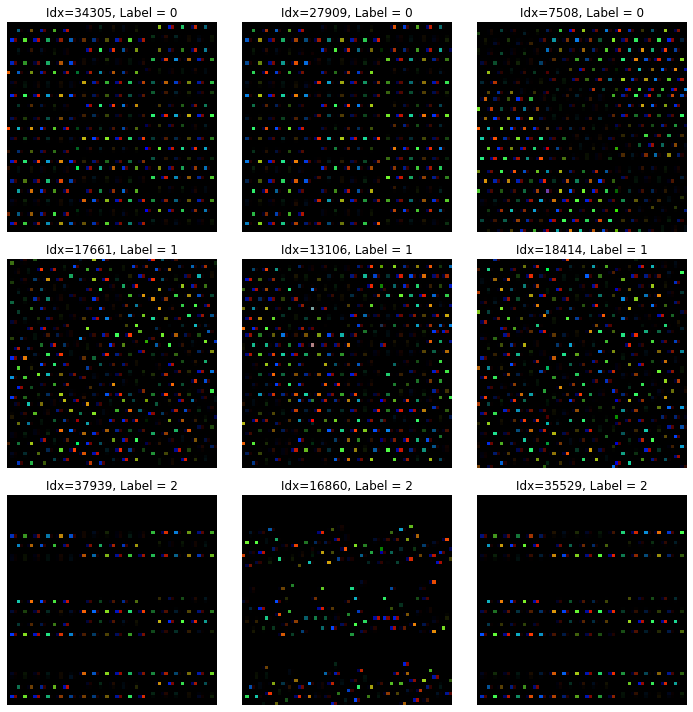

In [12]:
n = train_data.labels.shape[0]
R, C = len(np.unique(train_data.labels)), 3
fig, ax = plt.subplots(R, C, figsize = (10,10))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_data.labels == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        idx = np.random.choice(label_x_rows)
        img = train_data.feature_vec[idx].reshape((64,64,3))
        y = train_data.labels[idx]
        plot_cell.imshow(img)
        plot_cell.set_title('Idx=%d, Label = %d' %(idx, label_class))

plt.tight_layout()
# img1 = train_data.feature_vec[idx1].reshape((64,64,3))
# img2 = train_data.feature_vec[idx2].reshape((64,64,3))
# img3 = train_data.feature_vec[idx3].reshape((64,64,3))
# print(train_data.labels[idx1], train_data.labels[idx2], train_data.labels[idx3])
# ax1.imshow(img1)
# ax2.imshow(img2)
# ax3.imshow(img3)
# plt.tight_layout()

In [13]:
from torch.utils.data import TensorDataset,DataLoader,Dataset 
from torch.optim import SGD, Adam
from torchsummary import summary
import torch
import torch.nn as nn

In [23]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.25),
        nn.Conv2d(ni, no, kernel_size=3, stride = 1, padding = 'same'),
        nn.LeakyReLU(negative_slope=0.2),
        nn.MaxPool2d(2)
    )

class DefectClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            convBlock(3, 32),
            convBlock(32, 64),
            convBlock(64, 64),
            
            nn.Flatten(),
            nn.Linear(8*8*64, R) ) 
    
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
    

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    
    
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def test_batch(model, data, criterion):
    model.eval()
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [74]:
model = DefectClassification()
model.apply(initialize_weights)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-4)

In [75]:
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 32, 64, 64]             896
         LeakyReLU-3           [-1, 32, 64, 64]               0
         MaxPool2d-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
         LeakyReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
           Dropout-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
        LeakyReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                   

In [26]:
X_train = torch.tensor(train_data.feature_vec).float()
y_train = torch.tensor(train_data.labels, dtype = torch.int64)
print(X_train.shape, y_train.shape)
trn_dl = DataLoader(TensorDataset(X_train, y_train), 64, shuffle=True)

torch.Size([39564, 3, 64, 64]) torch.Size([39564])


In [70]:
from sklearn.model_selection import train_test_split

X_train = torch.tensor(train_data.feature_vec).float()
y_train = torch.tensor(train_data.labels, dtype = torch.int64)
print(X_train.shape, y_train.shape)

n = X_train.shape[0]
indices = np.arange(n)

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X_train, y_train, indices, test_size=0.6)
print(n, len(indices_train), len(indices_test))

trn_dl = DataLoader(TensorDataset(X_train, y_train), 64, shuffle=True)
test_dl = DataLoader(TensorDataset(X_test, y_test), 64, shuffle=True)

torch.Size([39564, 3, 64, 64]) torch.Size([39564])
39564 15825 23739


In [76]:
import time

n_epochs = 100

counter = 0
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
train_loss, test_loss = 0.0, 0.0
train_acc, test_acc = 0.0, 0.0

for ex in range(n_epochs):
    start = time.time()
    N = len(trn_dl)
    train_loss = 0
    train_acc = 0.0
    counter = 0
    
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        train_loss += loss
        train_acc += acc
        counter += 1
    
    train_loss /= float(counter)
    train_acc  /= float(counter)
    
    N = len(test_dl)
    test_loss, test_acc = 0.0, 0.0
    counter = 0
    for bx, data in enumerate(test_dl):
        loss, acc = test_batch(model, data, criterion)
        test_loss += loss
        test_acc += acc
        counter += 1
    
    test_loss /= float(counter)
    test_acc /= float(counter)
    
    
    print('%5d  Train Loss: %12.6f, Acc: %12.6f,   Test Loss: %12.6f, Acc: %12.6f, Time: %8.4f secs' %(ex, train_loss, train_acc, test_loss, test_acc, time.time() - start))
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    0  Train Loss:     0.585320, Acc:     0.815098,   Test Loss:     0.107703, Acc:     0.976075, Time:  98.9267 secs
    1  Train Loss:     0.094490, Acc:     0.976058,   Test Loss:     0.085516, Acc:     0.977507, Time:  92.4380 secs
    2  Train Loss:     0.080039, Acc:     0.976310,   Test Loss:     0.074116, Acc:     0.979528, Time:  92.8817 secs
    3  Train Loss:     0.071748, Acc:     0.977648,   Test Loss:     0.075057, Acc:     0.976741, Time:  93.0706 secs
    4  Train Loss:     0.064578, Acc:     0.978278,   Test Loss:     0.061060, Acc:     0.981550, Time:  92.0784 secs
    5  Train Loss:     0.059700, Acc:     0.980973,   Test Loss:     0.054667, Acc:     0.981929, Time:  91.4662 secs
    6  Train Loss:     0.053420, Acc:     0.982989,   Test Loss:     0.053360, Acc:     0.983234, Time:  91.1832 secs
    7  Train Loss:     0.048123, Acc:     0.984375,   Test Loss:     0.051721, Acc:     0.984880, Time:  91.4357 secs
    8  Train Loss:     0.044192, Acc:     0.985761,   Te

   70  Train Loss:     0.000076, Acc:     1.000000,   Test Loss:     0.078763, Acc:     0.991068, Time:  90.9818 secs
   71  Train Loss:     0.000063, Acc:     1.000000,   Test Loss:     0.081974, Acc:     0.990815, Time:  91.0874 secs
   72  Train Loss:     0.000055, Acc:     1.000000,   Test Loss:     0.079520, Acc:     0.990692, Time:  91.9143 secs
   73  Train Loss:     0.000066, Acc:     1.000000,   Test Loss:     0.082183, Acc:     0.990903, Time:  91.4168 secs
   74  Train Loss:     0.000049, Acc:     1.000000,   Test Loss:     0.085014, Acc:     0.990777, Time:  92.3300 secs
   75  Train Loss:     0.000038, Acc:     1.000000,   Test Loss:     0.084511, Acc:     0.991029, Time:  91.5456 secs
   76  Train Loss:     0.000034, Acc:     1.000000,   Test Loss:     0.087379, Acc:     0.990857, Time:  91.2730 secs
   77  Train Loss:     0.000027, Acc:     1.000000,   Test Loss:     0.087038, Acc:     0.991156, Time:  91.3946 secs
   78  Train Loss:     0.000035, Acc:     1.000000,   Te

In [77]:
def plot_data(x, y1, y2, xlabel, ylabel, xticks, yticks, title):
    plt.xlabel(xlabel, fontsize = 30, fontname = 'Arial', fontweight = 'bold')
    plt.ylabel(ylabel, fontsize = 30, fontname = 'Arial', fontweight = 'bold')
    plt.xticks(xticks, fontsize = 24, fontweight = 'bold', fontname = 'Arial')
    plt.yticks(yticks, fontsize = 24, fontweight = 'bold', fontname = 'Arial')
    plt.title(title, fontsize = 30, fontweight = 'bold', fontname = 'Arial')
    plt.plot(x, y1, linewidth = 5.0, label = 'Train', color = 'red')
    plt.plot(x, y2, linewidth = 5.0, label = 'Test', color = 'blue')
    plt.legend(fontsize = 30)

In [80]:
plt.figure(figsize = (20, 10), dpi = 600)
n = 20
epochs = list(np.arange(1, n+1))

plt.subplot(1, 2, 1)
plot_data(epochs, train_losses[:n], test_losses[:n], 'Epochs', 'Loss', [5, 10, 15, 20], [0, 0.10, 0.20, 0.30, 0.40], 'Loss vs Epoch')

plt.subplot(1, 2, 2)
plot_data(epochs, train_accuracies[:n], test_accuracies[:n], 'Epochs', 'Accuracy', [5, 10, 15, 20], [0.85, 0.90, 0.95, 1.00], 'Accuracy vs Epoch')

plt.savefig('CNN_plot.png')

In [222]:
natoms = test_data.feature_vec.shape[0]
natoms
x = torch.tensor(test_data.feature_vec[0][None]).float()
x.shape

torch.Size([1, 3, 64, 64])

In [223]:
test_data.coordinate.shape

(8400, 4)

In [224]:
# Generate labels from trained model and write them in a file
fileName = 'Mo_labelled_from_CNN.xyz'
fh = open(fileName, 'w')
natoms = test_data.coordinate.shape[0]
fh.write('%d\n\n' %natoms)

for i in range(natoms):
    x = torch.tensor(test_data.feature_vec[i][None]).float()
    pred = torch.max(model(x), 1)[1]
    true = test_data.labels[i]
    x, y, z, aty = test_data.coordinate[i]
    fh.write('%d %12.6f %12.6f %12.6f %d %d\n' %(aty, x, y, z, pred, true))
    #print(pred, true)

fh.close()

In [225]:
print(list(test_data.labels).count(0), list(test_data.labels).count(1), list(test_data.labels).count(2))

1640 6548 212
